# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch17/ch17_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-19 09:16:30--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-19 09:16:30 (21.5 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torchvision': '0.9.0',
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
}

check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] torch 2.0.1+cu118
[OK] torchvision 0.15.2+cu118
[OK] numpy 1.23.5
[OK] matplotlib 3.7.1


# 새로운 데이터 합성을 위한 생성적 적대 신경망 (파트 2/2)

**목차**

- 합성곱 GAN과 바서슈타인 GAN으로 합성 이미지 품질 높이기
  - 전치 합성곱
  - 배치 정규화
  - 생성자와 판별자 구현
  - 두 분포 사이의 거리 측정
  - GAN에 EM 거리 사용
  - 그레이디언트 페널티
  - WGAN-GP로 DCGAN 모델 훈련
  - 모드 붕괴
  - 다른 GAN 애플리케이션
- 요약

In [3]:
from IPython.display import Image
%matplotlib inline

# 합성곱 GAN과 바서슈타인 GAN으로 합성 이미지 품질 높이기


## 전치 합성곱


In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_09.png', width=700)

In [5]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_10.png', width=700)

## 배치 정규화


In [6]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_11.png', width=700)

## 생성자와 판별자 구현


In [7]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_12.png', width=700)

In [8]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_13.png', width=700)

In [9]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [10]:
import torch


print(torch.__version__)
print("GPU 사용:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.0.1+cu118
GPU 사용: True


In [11]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## 데이터셋 준비
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 38489257.67it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38189058.58it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65257186.77it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7865618.81it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:
## 손실 함수와 옵티마이저:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [ ]:
## 판별자 훈련
def d_train(x):
    disc_model.zero_grad()

    # 진짜 배치에서 판별자 훈련
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # 가짜 배치에서 판별자 훈련
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # 그레이디언트 역전파와 판별자 파라미터 최적화
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
## 생성자 훈련
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # 그레이디언트 역전파와 생성자 파라미터 최적화
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'에포크 {epoch:03d} | 평균 손실 >>'
          f' 생성자/판별자 {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 평균 손실 >> 생성자/판별자 4.8412/0.1003
에포크 002 | 평균 손실 >> 생성자/판별자 4.6619/0.1380
에포크 003 | 평균 손실 >> 생성자/판별자 3.8566/0.2510
에포크 004 | 평균 손실 >> 생성자/판별자 3.2235/0.3074
에포크 005 | 평균 손실 >> 생성자/판별자 3.0864/0.2983
에포크 006 | 평균 손실 >> 생성자/판별자 3.0270/0.3158
에포크 007 | 평균 손실 >> 생성자/판별자 3.0143/0.3278
에포크 008 | 평균 손실 >> 생성자/판별자 2.9769/0.2738
에포크 009 | 평균 손실 >> 생성자/판별자 3.1296/0.2795
에포크 010 | 평균 손실 >> 생성자/판별자 3.1026/0.2682
에포크 011 | 평균 손실 >> 생성자/판별자 3.1839/0.2567
에포크 012 | 평균 손실 >> 생성자/판별자 3.2572/0.2363
에포크 013 | 평균 손실 >> 생성자/판별자 3.3870/0.2382
에포크 014 | 평균 손실 >> 생성자/판별자 3.4324/0.2241
에포크 015 | 평균 손실 >> 생성자/판별자 3.5492/0.1987
에포크 016 | 평균 손실 >> 생성자/판별자 3.5649/0.2158
에포크 017 | 평균 손실 >> 생성자/판별자 3.5711/0.2264
에포크 018 | 평균 손실 >> 생성자/판별자 3.5702/0.2138
에포크 019 | 평균 손실 >> 생성자/판별자 3.6933/0.1886
에포크 020 | 평균 손실 >> 생성자/판별자 3.6656/0.2095
에포크 021 | 평균 손실 >> 생성자/판별자 3.7637/0.1952
에포크 022 | 평균 손실 >> 생성자/판별자 3.7060/0.1885
에포크 023 | 평균 손실 >> 생성자/판별자 3.7643/0.1907
에포크 024 | 평균 손실 >> 생성자/판별자 3.7380/0.2260
에포크 025 | 평균 손실 

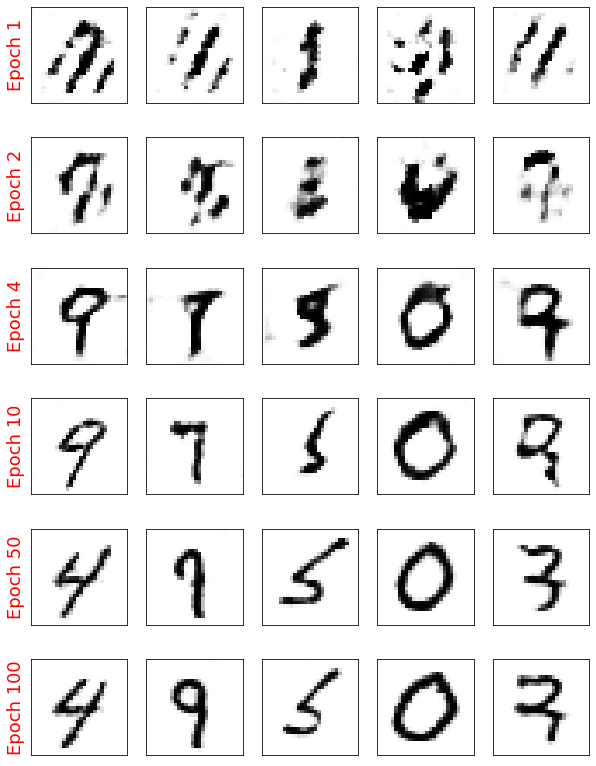

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

## 두 분포 사이의 거리 측정


In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_14.png', width=700)

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_15.png', width=800)

## GAN에 EM 거리 사용


## 그레이디언트 페널티


## WGAN-GP로 DCGAN 모델 훈련


In [ ]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [ ]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # 보간 계산
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # 보간된 샘플의 확률 계산
    proba_interpolated = disc_model(interpolated)

    # 샘플에 대한 확률의 그레이디언트 계산
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()


In [ ]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # 진짜 데이터와 생성된 데이터의 확률 계산
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [ ]:
## 생성자 훈련
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # 그레이디언트 역전파와 생성자 파라미터 최적화
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'에포크 {epoch:03d} | 판별자 손실 >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 판별자 손실 >> -0.3032
에포크 002 | 판별자 손실 >> -0.5580
에포크 003 | 판별자 손실 >> -0.6006
에포크 004 | 판별자 손실 >> -0.6240
에포크 005 | 판별자 손실 >> -0.6449
에포크 006 | 판별자 손실 >> -0.6293
에포크 007 | 판별자 손실 >> -0.5722
에포크 008 | 판별자 손실 >> -0.5399
에포크 009 | 판별자 손실 >> -0.5213
에포크 010 | 판별자 손실 >> -0.5102
에포크 011 | 판별자 손실 >> -0.4978
에포크 012 | 판별자 손실 >> -0.4827
에포크 013 | 판별자 손실 >> -0.4860
에포크 014 | 판별자 손실 >> -0.4765
에포크 015 | 판별자 손실 >> -0.4713
에포크 016 | 판별자 손실 >> -0.4597
에포크 017 | 판별자 손실 >> -0.4557
에포크 018 | 판별자 손실 >> -0.4584
에포크 019 | 판별자 손실 >> -0.4530
에포크 020 | 판별자 손실 >> -0.4595
에포크 021 | 판별자 손실 >> -0.4549
에포크 022 | 판별자 손실 >> -0.4609
에포크 023 | 판별자 손실 >> -0.4621
에포크 024 | 판별자 손실 >> -0.4619
에포크 025 | 판별자 손실 >> -0.4553
에포크 026 | 판별자 손실 >> -0.4636
에포크 027 | 판별자 손실 >> -0.4599
에포크 028 | 판별자 손실 >> -0.4626
에포크 029 | 판별자 손실 >> -0.4633
에포크 030 | 판별자 손실 >> -0.4654
에포크 031 | 판별자 손실 >> -0.4666
에포크 032 | 판별자 손실 >> -0.4608
에포크 033 | 판별자 손실 >> -0.4665
에포크 034 | 판별자 손실 >> -0.4656
에포크 035 | 판별자 손실 >> -0.4674
에포크 036 | 판별자 손실 >> 

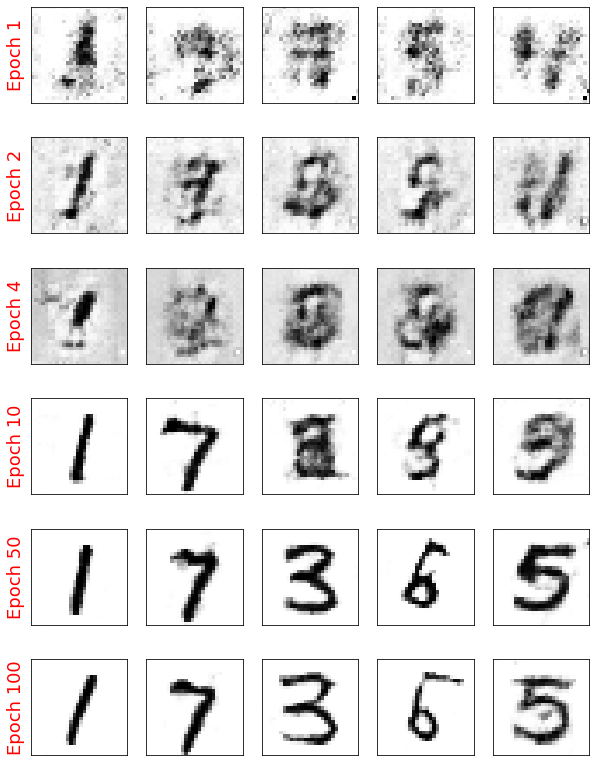

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-wgan-gp-samples.pdf')
plt.show()


## 모드 붕괴


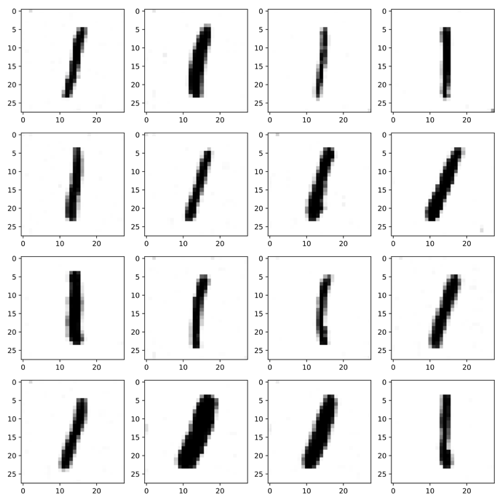

In [ ]:
Image(filename='figures/17_16.png', width=600)

## 다른 GAN 애플리케이션
# 요약